In [144]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import tensorflow as tf

In [145]:
TRAIN_DIR = 'Emotions/train'
TEST_DIR = "Emotions/test"
batch_size = 64
img_height, img_width = 224, 224

In [174]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    labels='inferred',
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    validation_split=0.2,
    labels='inferred',
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size, shuffle=True)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 7178 files belonging to 7 classes.
Using 1435 files for validation.


In [178]:
#Number of emotions
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [187]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
i = tf.keras.layers.Input(shape=[img_width, img_height, 3], dtype=tf.uint8)
x = tf.cast(i, tf.float32)

pretrained = tf.keras.applications.resnet50.ResNet50(input_shape=(img_width, img_height, 3), include_top=False,
                                                     weights="imagenet",
                                                     classes=num_classes, classifier_activation="softmax")
model = tf.keras.models.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_69 (Dense)            (None, 256)               524544    
                                                                 
 dense_70 (Dense)            (None, 64)                16448     
                                                                 
 dense_71 (Dense)            (None, 7)                 455       
                                                                 
Total params: 24,129,159
Trainable params: 24,076,039
Non-trainable params: 53,120
____________________________________

In [189]:
callbacks = tf.keras.callbacks.ModelCheckpoint("emotion.h5", save_best_only=True)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20


2023-02-09 03:48:34.884310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.5041

2023-02-09 03:52:10.083055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 224s 598ms/step - loss: 1.3052 - accuracy: 0.5041 - val_loss: 1.6716 - val_accuracy: 0.3512
Epoch 2/20
359/359 [==============================] - 223s 620ms/step - loss: 1.0932 - accuracy: 0.5859 - val_loss: 1.5224 - val_accuracy: 0.4167
Epoch 3/20
359/359 [==============================] - 227s 629ms/step - loss: 0.9745 - accuracy: 0.6356 - val_loss: 1.7653 - val_accuracy: 0.3498
Epoch 4/20
359/359 [==============================] - 228s 633ms/step - loss: 0.8678 - accuracy: 0.6726 - val_loss: 1.4022 - val_accuracy: 0.5296
Epoch 5/20
359/359 [==============================] - 227s 630ms/step - loss: 0.7671 - accuracy: 0.7141 - val_loss: 1.4871 - val_accuracy: 0.5226
Epoch 6/20
359/359 [==============================] - 223s 617ms/step - loss: 0.6571 - accuracy: 0.7593 - val_loss: 1.6822 - val_accuracy: 0.4634
Epoch 7/20
359/359 [==============================] - 220s 611ms/step - loss: 0.5352 - accuracy: 0.8065 - val_loss: 1.6674 - val_accura

In [190]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.305162,0.504136,1.671572,0.351220
1,1.093171,0.585902,1.522427,0.416725
2,0.974486,0.635624,1.765332,0.349826
3,0.867841,0.672588,1.402158,0.529617
4,0.767117,0.714124,1.487130,0.522648
5,0.657107,0.759274,1.682172,0.463415
6,0.535215,0.806470,1.667420,0.484321
7,0.443541,0.839472,1.565200,0.520558
8,0.339192,0.877699,2.150149,0.466899
9,0.264957,0.904824,2.339977,0.444599


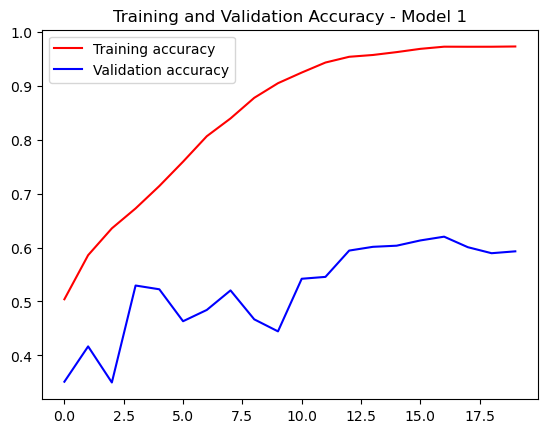

<Figure size 640x480 with 0 Axes>

In [193]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy - Model 1')
plt.legend(loc=0)
plt.figure()

plt.show()

23/23 [==============================] - 4s 161ms/step - loss: 1.9827 - accuracy: 0.5930


[1.982668399810791, 0.5930314064025879]